In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs

from dataclasses import dataclass
from collections import defaultdict

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.init_project(name="2d-osc-shear", root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12], '_status': {}}

In [4]:
cell = freud.data.UnitCell([1.0, 1.0, 0.0, 0.5, 0.0, 0.0])
cell.a1, cell.a2, cell.a3

(array([1., 0., 0.]), array([0.5, 1. , 0. ]), array([0., 0., 0.]))

In [5]:
cell.lattice_vectors

array([[1. , 0.5, 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 0. ]])

In [6]:
box, pos = cell.generate_system(200, sigma_noise=0.1)

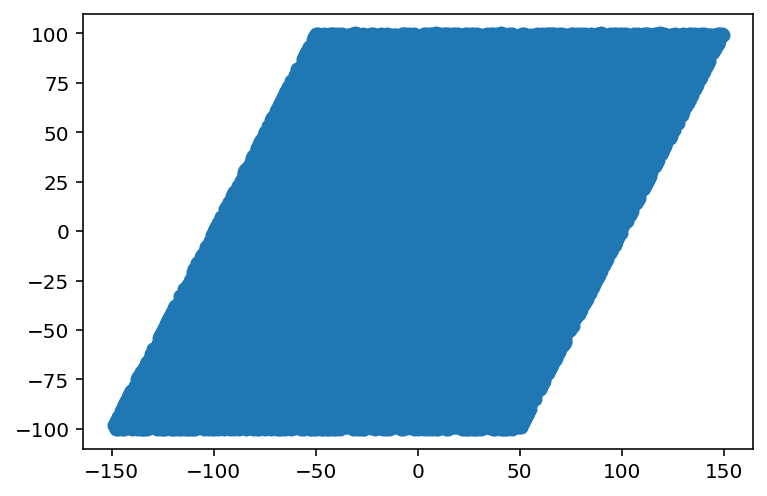

In [7]:
plt.scatter(pos[:, 0], pos[:, 1])

In [8]:
len(pos)

40000

In [9]:
voro = freud.locality.Voronoi()

In [10]:
voro

freud.locality.Voronoi()

In [11]:
# %timeit
voro.compute((box, pos));

In [12]:
voro.compute((box, pos));

In [21]:
voro.nlist.point_indices

array([    1,   199,   200, ..., 39799, 39800, 39998], dtype=uint32)

In [13]:
voro.polytopes[0], voro.polytopes[1]

(array([[-0.5906906 , -0.49922151,  0.        ],
        [ 0.1200648 , -0.7834663 ,  0.        ],
        [ 0.65974817, -0.47314064,  0.        ],
        [ 0.380017  ,  0.40876484,  0.        ],
        [ 0.05844776,  0.52493352,  0.        ],
        [-0.47597393,  0.34924625,  0.        ]]),
 array([[ 0.05844776,  0.52493352,  0.        ],
        [ 0.380017  ,  0.40876484,  0.        ],
        [ 0.94835326,  0.77187714,  0.        ],
        [ 0.97496456,  1.29157311,  0.        ],
        [ 0.49463874,  1.65032044,  0.        ],
        [-0.02328106,  1.40588371,  0.        ]]))

In [80]:
voro.volumes

array([0.99180669, 1.13114805, 0.98887449, 0.96164491, 0.91742674,
       1.08221922, 0.98762729, 0.99906053, 0.9721647 , 1.04942339,
       1.11594441, 0.98647268, 1.10466541, 1.03488064, 1.10703559,
       1.08464438, 0.98592541, 0.9573491 , 1.0269191 , 1.121199  ,
       0.94394742, 1.01039647, 0.98665894, 0.9271562 , 1.03453532,
       0.88215067, 0.90424198, 0.95965092, 0.97060325, 0.98528281,
       0.90489583, 1.09739397, 0.93538185, 1.08141818, 1.02261004,
       1.17772629, 1.06062748, 1.00466698, 0.94208192, 0.92443445,
       0.96923664, 0.87166897, 1.09113186, 1.2014084 , 1.08493784,
       0.86372244, 0.85701124, 0.99355249, 1.04979565, 1.01483304,
       0.8672377 , 0.87158615, 0.89432363, 1.12818386, 0.98089165,
       0.84864649, 0.94914064, 1.05719237, 1.11077617, 1.01387871,
       1.11105185, 0.87125651, 0.96211511, 1.05245539, 1.06060557,
       0.87025937, 0.94462392, 1.00789966, 0.99431492, 1.04657527,
       1.11761217, 1.02594776, 1.14289376, 1.0181722 , 0.89786

In [84]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float

In [102]:
# get d2min distribution

rev_quant = defaultdict(list)

for job in project:
    print(job)

    expers = sorted(glob.glob(job.fn("experiments/*/*/*")))

    for exper in expers:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp))
        
        # if float(period) != 1000.0:
        #     continue

        traj = gsd.hoomd.open(exper)

        print(max_shear, period, temp)

        # d2mins = []
        quants = []
        voro = freud.locality.Voronoi()
        for i in range(1, 20):

            snap = traj[-1 + i*40]
            snap_high = traj[9 + i*40]
            snap_later = traj[-1 + (i+1)*40]
            snap_low = traj[29 + i*40]

            box = snap.configuration.box[:]
            box_high = snap_high.configuration.box[:]
            box_later = snap_later.configuration.box[:]
            box_low = snap_low.configuration.box[:]

            # nlist_query = freud.locality.AABBQuery.from_system(snap)
            # nlist = nlist_query.query(snap.particles.position, {'num_neighbors': 20}).toNeighborList()
            voro.compute((box_high, snap_high.particles.position)).nlist

            # d2min_irr = schmeud_rs.dynamics.d2min_frame(snap.particles.position[:, :2], snap_later.particles.position[:, :2], nlist.query_point_indices, nlist.point_indices, (box, box_later))
            # d2min_rev = schmeud_rs.dynamics.d2min_frame(snap_high.particles.position[:, :2], snap_low.particles.position[:, :2], nlist.query_point_indices, nlist.point_indices, (box_high, box_low))
            # quant = np.square(d2min_rev) - np.square(d2min_irr)
            # quant = np.mean(quant > 0)
            # quants.append(quant)
            break
        # rev_quant[sp].append(quants)
        break
    break

# save to pickle
# with open(project.fn("results/rev-quant.pkl"), "wb") as f:
#     pickle.dump(rev_quant, f)

634e14bc75836df75158fb15f379d8bb
0.01 100.0 0.0496


In [106]:
# fig, ax = plt.subplots(dpi=300)
# voro.plot(ax=ax)
# ax.set_xlim(-20, 10)
# ax.set_ylim(-20, 10)